<span style="font-size:20pt;">**1. Project Initialization & Data Acquisition**</span>

**Project:** Streaming Insights based on Content Performance (user characteristics will be subject to a different analysis).

**Strategic Context:** The project aims to inform the marketing, investment, and promotion teams in a major streaming platform.

**Core Business Goal:** To identify and quantify the key characteristics that define movie success—measured by user engagement, high ratings, release year and directors to drive future investment decisions.

<span style="font-size:13pt;">**Key Business Questions Driving Analysis:**</span>

**Genre Performance:** Which genres consistently outperform the platform average in terms of user rating and popularity, indicating high-value acquisition targets?

**Popularity Drivers:** What relationship exists between a movie's release year, its director's popularity, and its overall success metric?

<span style="font-size:13pt;">**Next Step:** Setup and Database Connection-  The first step is importing the required libraries and establishing the connection to the SQLite database file (locally) containing the raw MUBI data. </span>

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Define the database file path (assuming the file is in the same directory).
DB_FILE = 'mubi_db.sqlite' 

# Establish the connection to the SQLite database.
try:
    connection = sqlite3.connect(DB_FILE)
    print(f"Successfully connected to the database: {DB_FILE}")
except sqlite3.Error as e:
    print(f"An error occurred: {e}")
    connection = None

# If connection is successful, display the available tables to verify data loading.
if connection is not None:
    # SQL query to retrieve all table names in the database.
    query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
    
    # Execute the query and load results into a DataFrame.
    df_tables = pd.read_sql_query(query_tables, connection)
    
    print("\n--- Available Data Tables ---")
    print(df_tables)

Successfully connected to the database: mubi_db.sqlite

--- Available Data Tables ---
            name
0         movies
1  ratings_users
2    lists_users
3          lists
4        ratings


<span style="font-size:13pt;">***Observation:*** All expected tables exist in the dataset, which aligns with the Kaggle "About Dataset" documentation.</span>

<span style="font-size:20pt;">**2. Data exploration & Quality check**</span>

Before performing the main analysis, I will conduct an initial data assessment. This is critical for ensuring data quality and enabling deeper analysis.

<span style="font-size:13pt;">**Goals of this section:**</span>

**>** Examine the null values.

**>** Explore the unique movies and ratings in the **tables** to identify and clean duplicates.

**>** Check for ratings of movies that **aren't** registered on MUBI (data integrity check).

**>** Construct/define the final table structure.

<span style="font-size:13pt;">***Next step:*** Examine the structure and null values for the **`movies`** table to avoid skewed results.</span>

In [2]:
# Query to load the full movies table into a DataFrame.
df_movies = pd.read_sql_query("SELECT * FROM movies;", connection) 

# Display the table summary (data types and null counts).
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226575 entries, 0 to 226574
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movie_id              226575 non-null  int64  
 1   movie_title           226575 non-null  object 
 2   movie_release_year    226570 non-null  float64
 3   movie_url             226575 non-null  object 
 4   movie_title_language  226575 non-null  object 
 5   movie_popularity      226575 non-null  int64  
 6   movie_image_url       209157 non-null  object 
 7   director_id           226575 non-null  object 
 8   director_name         226572 non-null  object 
 9   director_url          226575 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 17.3+ MB


<span style="font-size:13pt;">***Observation:*** The `movies` table has 226,575 rows and three columns with missing values:</span>

* `movie_release_year`: 5 null values
* `director_name`: 3 null values
* `movie_image_url`: 17,418 null values
    
<span style="font-size:13pt;">***Next step:*** Impute the `movie_image_url` nulls with 'no_available_image_url' to prevent dropping rows later. I will then analyze the `movie_popularity` for entries missing `movie_release_year` or `director_name` to assess their importance to the overall analysis.</span>

In [3]:
# Query to update the null values of movie_image_url column
query_update_nulls = """
UPDATE movies
SET movie_image_url = 'no_available_image_url'
WHERE movie_image_url IS NULL;
"""

# Execute the update query using your connection object.
cursor = connection.cursor()
cursor.execute(query_update_nulls)

# Commit the changes to the database
connection.commit()


# Query to identify and retrieve movies with missing release year or director name.
query_missing_metadata = """
SELECT movie_id, movie_title, movie_release_year, director_name, movie_popularity
FROM movies
WHERE movie_release_year IS NULL OR director_name IS NULL;
"""

# run the query and save the results
df_missing_metadata = pd.read_sql_query(query_missing_metadata, connection)

# show the results
df_missing_metadata

,movie_id,movie_title,movie_release_year,director_name,movie_popularity
0,100526,The Overcoat,NaN,Yuriy Norshteyn,3
1,114131,Found in Trash,NaN,Adam Cooley,0
2,127691,The Bear Man of Kamchatka,2008.0,None,2
3,129735,Severed Footage,2012.0,None,0
4,129742,Dominium,2013.0,None,0
5,134787,Phantom Ore,NaN,Myron Ort,1
6,134788,New York Kino,NaN,Myron Ort,0
7,134790,Awakener,NaN,Myron Ort,0


<span style="font-size:13pt;">***Conclusion:*** Since only **8 rows** contain missing `movie_release_year` or `director_name` (out of 226,575 total), and these films exhibit very low `movie_popularity`, these specific nulls can be safely ignored for the current analysis. However, the platform's technical team should be **notified** to address and fix these data issues.</span>

<span style="font-size:13pt;">***Next step:*** Validate the uniqueness of movie entries in the **`movies`** table to ensure the analysis is accurate and not influenced by repeated data points.</span>

In [4]:
# Query to get the count of total rows, unique movie ids and titles.
query_movie_counts = """
SELECT 
    COUNT(movie_id) as total_rows,
    COUNT(DISTINCT movie_id) as unique_movie_ids,
    COUNT(DISTINCT movie_title) as unique_movie_titles
FROM 
    movies;
"""

# Run the query.
df_movie_counts = pd.read_sql_query(query_movie_counts, connection)

# Print the results .
print("--- Movie Count Summary ---")
df_movie_counts

--- Movie Count Summary ---


,total_rows,unique_movie_ids,unique_movie_titles
0,226575,226575,196628


<span style="font-size:13pt;">***Observation:*** The **`movie_id`** column is unique, but the **`movie_title`** column contains non-unique entries (there are 29,947 more total rows than unique titles).</span>

<span style="font-size:13pt;">***Next step:*** Investigate whether the non-unique movie titles represent true duplicates of the same film or different film versions that share the same title.</span>

In [5]:
# Query to identify movie titles with multiple entries and count their occurrences.
query_duplicated_titles_count = """
SELECT COUNT(*) as title_count, movie_title
FROM movies
GROUP BY movie_title
HAVING title_count > 1
ORDER BY title_count DESC;
"""
# Run the query.
df_duplicated_titles_count = pd.read_sql_query(query_duplicated_titles_count, connection)

# Show the results.
df_duplicated_titles_count

,title_count,movie_title
0,47,Home
1,34,The Return
2,33,Mother
3,30,Alone
4,28,Silence
...,...,...
14663,2,1001 Nights
14664,2,100 días de soledad
14665,2,100 Years
14666,2,10 Minutes


<span style="font-size:13pt;">***Observation:*** There are 14,668 unique movie titles, ranging in frequency from 2 to 47 occurrences.</span>

<span style="font-size:13pt;">***Next step:*** To determine the nature of the title duplication, I will verify if rows with identical movie titles are duplicated across all other fields (e.g., release year, director) or if they are different movies that simply share the same title.</span>

In [6]:
# Query to check for true, full-row duplicates among entries that share a movie_title(not include movie_id).
query_true_duplicates_check = """
WITH TitleVariability AS (
    SELECT
        movie_title,
        COUNT(movie_id) AS total_entries,
        COUNT(DISTINCT movie_release_year) AS distinct_year,
        COUNT(DISTINCT director_name) AS distinct_directors,
        COUNT(DISTINCT movie_url) AS distinct_urls,
        COUNT(DISTINCT movie_title_language) AS distinct_languages,
        COUNT(DISTINCT movie_popularity) AS distinct_popularity,
        COUNT(DISTINCT movie_image_url) AS distinct_img_urls,
        COUNT(DISTINCT director_id) AS distinct_director_ids,
        COUNT(DISTINCT director_url) AS distinct_director_urls
    FROM
        movies
    WHERE
        movie_title IN (
            SELECT movie_title FROM movies GROUP BY movie_title HAVING COUNT(*) > 1
        )
    GROUP BY 
        movie_title
)
SELECT *
FROM TitleVariability
WHERE 
    total_entries = distinct_year AND 
    total_entries = distinct_directors AND 
    total_entries = distinct_urls AND 
    total_entries = distinct_languages AND 
    total_entries = distinct_popularity AND
    total_entries = distinct_img_urls AND 
    total_entries = distinct_director_ids AND 
    total_entries = distinct_director_urls;
"""

# Run the query and save the results.
df_true_duplicates_check = pd.read_sql_query(query_true_duplicates_check, connection)

# Show the results.
df_true_duplicates_check

,movie_title,total_entries,distinct_year,distinct_directors,distinct_urls,distinct_languages,distinct_popularity,distinct_img_urls,distinct_director_ids,distinct_director_urls


In [7]:
# Query to retrieve all rows associated with duplicated titles for sample inspection.
query_duplicate_titles_field = """
SELECT *
FROM movies
WHERE movie_title IN (
    SELECT movie_title
    FROM movies
    GROUP BY movie_title
    HAVING COUNT(*) > 1
)
ORDER BY movie_title;
"""

# Run the query and save the results.
df_duplicate_titles_full_records = pd.read_sql_query(query_duplicate_titles_field, connection)

# Show the results.
df_duplicate_titles_full_records

,movie_id,movie_title,movie_release_year,movie_url,movie_title_language,movie_popularity,movie_image_url,director_id,director_name,director_url
0,179741,#blessed,2017.0,http://mubi.com/films/blessed-2017,en,0,https://images.mubicdn.net/images/film/179741/...,127533,Diogo Lopes,http://mubi.com/cast/diogo-lopes
1,235353,#blessed,2015.0,http://mubi.com/films/blessed-2015,en,0,https://images.mubicdn.net/images/film/235353/...,"704380, 704381","Kailee McGee, Rich Costales","http://mubi.com/cast/kailee-mcgee, http://mubi..."
2,81826,1,2009.0,http://mubi.com/films/1-2009,en,0,https://images.mubicdn.net/images/film/81826/c...,298870,Pater Sparrow,http://mubi.com/cast/pater-sparrow
3,121813,1,2013.0,http://mubi.com/films/1-2013-paul-crowder,en,0,https://images.mubicdn.net/images/film/121813/...,50231,Paul Crowder,http://mubi.com/cast/paul-crowder
4,239045,1,2001.0,http://mubi.com/films/1-2001,en,0,https://images.mubicdn.net/images/film/239045/...,219233,Shelly Silver,http://mubi.com/cast/shelly-silver
...,...,...,...,...,...,...,...,...,...,...
44610,109873,À la mode,1993.0,http://mubi.com/films/a-la-mode-1993,en,0,https://images.mubicdn.net/images/film/109873/...,212512,Rémy Duchemin,http://mubi.com/cast/remy-duchemin
44611,104200,Étude,1961.0,http://mubi.com/films/etude,en,0,https://images.mubicdn.net/images/film/104200/...,87750,István Gaál,http://mubi.com/cast/istvan-gaal
44612,175684,Étude,2016.0,http://mubi.com/films/etude-2016,en,0,https://images.mubicdn.net/images/film/175684/...,23380,Robert Duncan,http://mubi.com/cast/robert-duncan
44613,203866,Été,2017.0,http://mubi.com/films/ete,en,0,https://images.mubicdn.net/images/film/203866/...,617322,Gregory Oke,http://mubi.com/cast/gregory-oke


<span style="font-size:13pt;">***Conclusion:*** The first check for **true, full-row duplicates** among the title-duplicated entries was successful, as the query returned an empty table. The second check confirms in general that entries sharing a title are distinct films (or versions) with unique metadata fields (e.g., director, release year, URL). The presence of numerous shared titles is an important piece of information for the analysis and must be communicated to the teams to ensure they do **not rely on the title as a unique movie identifier**.</span>

<span style="font-size:13pt;">***Next step:*** Examine the structure and null values for the **`ratings`** table to avoid skewed results.</span>

In [8]:
# Query to load the full ratings table into a DataFrame.
df_ratings = pd.read_sql_query("SELECT * FROM ratings;", connection) 

# Display the table summary (data types and null counts).
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15520005 entries, 0 to 15520004
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   movie_id                 int64  
 1   rating_id                int64  
 2   rating_url               object 
 3   rating_score             float64
 4   rating_timestamp_utc     object 
 5   critic                   object 
 6   critic_likes             int64  
 7   critic_comments          int64  
 8   user_id                  int64  
 9   user_trialist            float64
 10  user_subscriber          float64
 11  user_eligible_for_trial  float64
 12  user_has_payment_method  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 1.5+ GB


<span style="font-size:13pt;">***Observation:*** The **`ratings`** table is too large for the **.info()** method to quickly compute non-null counts, but the column data types have been successfully retrieved.

<span style="font-size:13pt;">***Next step:*** Use SQL to efficiently calculate the null counts for each column in the **`ratings`** table.</span>

In [9]:
# Query to get the number of null values for each column.
query_ratings_nulls = """
SELECT
    -- Count NULLs for each column in the ratings table
    SUM(CASE WHEN movie_id IS NULL THEN 1 ELSE 0 END) AS movie_id_nulls,
    SUM(CASE WHEN rating_id IS NULL THEN 1 ELSE 0 END) AS rating_id_nulls,
    SUM(CASE WHEN rating_url IS NULL THEN 1 ELSE 0 END) AS rating_url_nulls,
    SUM(CASE WHEN rating_score IS NULL THEN 1 ELSE 0 END) AS rating_score_nulls,
    SUM(CASE WHEN rating_timestamp_utc IS NULL THEN 1 ELSE 0 END) AS rating_timestamp_utc_nulls,
    SUM(CASE WHEN critic IS NULL THEN 1 ELSE 0 END) AS critic_nulls,
    SUM(CASE WHEN critic_likes IS NULL THEN 1 ELSE 0 END) AS critic_likes_nulls,
    SUM(CASE WHEN critic_comments IS NULL THEN 1 ELSE 0 END) AS critic_comments_nulls,
    SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) AS user_id_nulls,
    SUM(CASE WHEN user_trialist IS NULL THEN 1 ELSE 0 END) AS user_trialist_nulls,
    SUM(CASE WHEN user_subscriber IS NULL THEN 1 ELSE 0 END) AS user_subscriber_nulls,
    SUM(CASE WHEN user_eligible_for_trial IS NULL THEN 1 ELSE 0 END) AS user_eligible_for_trial_nulls,
    SUM(CASE WHEN user_has_payment_method IS NULL THEN 1 ELSE 0 END) AS user_has_payment_method_nulls
FROM ratings;
"""
# Execute the query
df_null_counts_sql = pd.read_sql_query(query_ratings_nulls, connection)

# Transpose the result and rename for clarity
df_null_counts_final = df_null_counts_sql.T.rename(columns={df_null_counts_sql.T.columns[0]: 'Null Count'})
df_null_counts_final.index.name = 'Column Name'

# Print the result table
print("--- Ratings Table Null Counts (SQL Method) ---")
print(df_null_counts_final)

--- Ratings Table Null Counts (SQL Method) ---
                               Null Count
Column Name                              
movie_id_nulls                          0
rating_id_nulls                         0
rating_url_nulls                        0
rating_score_nulls                  26731
rating_timestamp_utc_nulls              0
critic_nulls                     14771139
critic_likes_nulls                      0
critic_comments_nulls                   0
user_id_nulls                           0
user_trialist_nulls                     3
user_subscriber_nulls                   3
user_eligible_for_trial_nulls           3
user_has_payment_method_nulls           3


<span style="font-size:13pt;">***Next step:*** Investigate the **3 rows** that contain null values in the user characteristic columns to get full picture.</span>

In [10]:
# Query to retrieve the 3 rows missing user characteristic metadata.
query_ratings_nulls = """
SELECT *
FROM ratings
WHERE user_trialist IS NULL; 
"""

# Run the query and save the results.
df_ratings_nulls = pd.read_sql_query(query_ratings_nulls, connection)

# Show the results.
df_ratings_nulls

,movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,5678,13196014,http://mubi.com/films/memoirs-of-a-geisha/rati...,3.0,2015-12-01 14:30:05,None,0,0,38478306,None,None,None,None
1,149,16165319,http://mubi.com/films/pierrot-le-fou/ratings/1...,3.0,2017-11-02 10:30:05,None,0,0,46159561,None,None,None,None
2,315,12987469,http://mubi.com/films/dr-strangelove-or-how-i-...,4.0,2015-10-13 23:30:09,None,0,0,94559170,None,None,None,None


<span style="font-size:13pt;">***Conclusion:*** Based on the platform's rating system logic, the null values in the `ratings` table can be interpreted as follows:
1. **Missing User Flags (3 rows) ⚠️:** A negligible number of records show nulls across the 3 user metadata fields(can be ignored for this analysis). The specific **User IDs involved are 38478306, 46159561, and 94559170**, these user id must be reported for security \ data collecting teams, since they are mendatory fields.
2. **Missing Rating Scores (26,731 rows):** The absence of a `rating_score` in these records is considered **acceptable**. This likely represents cases where the score is optional (e.g., for critic reviews) or where users opted not to commit a score. Since this is a numerical column, nulls will be handled naturally by being excluded from calculations or by specific analytical queries that require a score.
3. **User Behavior Insight:** The high volume of nulls in the `critic` field ($14.77$ million) compared to the low volume of missing scores ($26,731$) suggests that users are far more willing to commit a simple `rating_score` than write a critic.
4. **Data Integrity:** The core identifier fields (`movie_id`, `rating_id`, `user_id`, etc.) exhibit $100\%$ completeness.

<span style="font-size:13pt;">***Next step:*** Validate the uniqueness of movies and ratings entries in the `ratings` table to ensure the analysis is accurate and not influenced by repeated data points.</span>

In [11]:
# Query to get all relevant counts in one go.
query_ratings_counts = """
SELECT 
    COUNT(*) as total_rows,
    COUNT(DISTINCT rating_id) as unique_rating_ids,
    COUNT(DISTINCT movie_id) as unique_movie_ids_rated
FROM 
    ratings;
"""

# Run the query and save the results.
df_ratings_counts = pd.read_sql_query(query_ratings_counts, connection)

# Show the results .
print("--- Ratings Count Summary ---")
df_ratings_counts

--- Ratings Count Summary ---


,total_rows,unique_rating_ids,unique_movie_ids_rated
0,15520005,15519997,142698


<span style="font-size:13pt;">***Observation:*** There are **8 duplicated** `rating_id`, representing a critical failure of the primary key constraint. The number of unique `movie_id` ($142,698$) is correctly much lower than the total number of rows, as expected, since each movie receives multiple ratings.

<span style="font-size:13pt;">***Next step:*** Verify if the rows associated with the duplicated `rating_id` are identical across all other columns, which would confirm them as **true duplicates** that can be safely deleted.</span>

In [12]:
# Query to get all the rows where rating_id is duplicated. 
query_duplicate_rating_rows = """
SELECT *
FROM ratings
WHERE rating_id IN (
    SELECT rating_id
    FROM ratings
    GROUP BY rating_id
    HAVING COUNT(rating_id) > 1
)
ORDER BY rating_id, user_id;
"""

# Run the query and save the results.
df_duplicate_ratings = pd.read_sql_query(query_duplicate_rating_rows, connection)

# Show the results.
df_duplicate_ratings

,movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,170,1212738,http://mubi.com/films/fargo/ratings/1212738,5.0,2009-11-26 05:38:59,None,0,0,73830827,0,0,1,0
1,170,1212738,http://mubi.com/films/fargo/ratings/1212738,5.0,2009-11-26 05:38:59,None,0,0,73830827,0,0,1,0
2,295,1281831,http://mubi.com/films/the-rules-of-the-game/ra...,5.0,2009-12-07 07:01:44,None,0,0,86576086,0,0,1,0
3,295,1281831,http://mubi.com/films/the-rules-of-the-game/ra...,5.0,2009-12-07 07:01:44,None,0,0,86576086,0,0,1,0
4,25120,8188057,http://mubi.com/films/wristcutters-a-love-stor...,4.0,2012-08-30 02:52:02,None,0,0,41579158,0,0,1,0
5,25120,8188057,http://mubi.com/films/wristcutters-a-love-stor...,4.0,2012-08-30 02:52:02,None,0,0,41579158,0,0,1,0
6,204,8271582,http://mubi.com/films/taxi-driver/ratings/8271582,5.0,2012-09-14 09:33:09,None,0,0,21206810,0,0,1,0
7,204,8271582,http://mubi.com/films/taxi-driver/ratings/8271582,5.0,2012-09-14 09:33:09,None,0,0,21206810,0,0,1,0
8,628,8786059,http://mubi.com/films/le-cercle-rouge/ratings/...,4.0,2013-01-04 03:58:09,None,0,0,80901349,0,0,1,0
9,628,8786059,http://mubi.com/films/le-cercle-rouge/ratings/...,4.0,2013-01-04 03:58:09,None,0,0,80901349,0,0,1,0


<span style="font-size:13pt;">***Observation:*** All the other fields are duplicated as well, confirming they are **true, redundant duplicates**.
    
<span style="font-size:13pt;">***Next step:*** Delete all redundant rows to restore the uniqueness of the `rating_id` primary key.</span>

In [13]:
# Query to delete redundant rows by identifying duplicates using ROW_NUMBER() and keeping only the first instance (rn=1).
query_delete_duplicate_ratings = """
WITH numbered_ratings AS (
SELECT rating_id, ROW_NUMBER() OVER (PARTITION BY rating_id ORDER BY rating_id) as rn
FROM ratings)

DELETE FROM ratings
WHERE rating_id IN (
SELECT rating_id
FROM numbered_ratings
WHERE rn > 1);
"""

# Execute the deletion query.
cursor = connection.cursor()
cursor.execute(query_delete_duplicate_ratings)

# Commit the changes to make them permanent.
connection.commit()

print("Deletion complete. 8 redundant rating_id rows removed.")

# --- Verification ---
# Query to get the total rows and unique ratings id after deletion.
query_verification = """
SELECT COUNT(DISTINCT rating_id) as num_unique_rating_id, COUNT(*) as num_rows_after_deletion
FROM ratings ;
"""

# Run the query and save the results.
df_verification = pd.read_sql_query(query_verification, connection)

# Print the results.
print("\nVerification Counts:")
print(df_verification)

Deletion complete. 8 redundant rating_id rows removed.

Verification Counts:
   num_unique_rating_id  num_rows_after_deletion
0              15519989                 15519989


<span style="font-size:13pt;">***Observation:*** The total number of rows ($15,519,989$) now equals the number of unique `rating_id` ($15,519,989$), confirming the deletion occurred successfully and the primary key constraint has been restored.

<span style="font-size:13pt;">***Next step:*** Check for **referential integrity** by identifying any `movie_id` in the `ratings` table that do not exist in the `movies` table.</span>

In [14]:
# Query to check for movie_id values in the ratings table that DO NOT exist in the movies table (Referential Integrity Check).
query_unregistered_movies = """
SELECT COUNT(r.movie_id) AS unregistered_ratings_count
FROM ratings AS r
LEFT JOIN movies AS m
ON r.movie_id = m.movie_id
WHERE m.movie_id IS NULL; 
"""

# Execute the query
df_nregistered_movies = pd.read_sql_query(query_unregistered_movies , connection)

# Print the results.
print(df_nregistered_movies)

   unregistered_ratings_count
0                          34


<span style="font-size:13pt;">***Observation:*** The referential integrity check confirmed **34 entries** in the `ratings` table reference a `movie_id` **that does not exist** in the `movies` table. These ratings are invalid and unusable, as we have no corresponding movie metadata.

<span style="font-size:13pt;">***Next step:*** Delete the **34 invalid rating rows** from the `ratings` table to maintain data quality and ensure every rating links to a registered MUBI film.</span>

In [15]:
# Query to delete all rows in the ratings table that reference an unregistered movie_id.
query_delete_unregistered_ratings = """
DELETE FROM ratings
WHERE movie_id IN (
SELECT r.movie_id
FROM ratings AS r
LEFT JOIN movies AS m
ON r.movie_id = m.movie_id
WHERE m.movie_id IS NULL
);
"""

# Execute the deletion query.
cursor = connection.cursor()
cursor.execute(query_delete_unregistered_ratings)

# Commit the changes to make them permanent.
connection.commit()

print("Deletion complete. 34 invalid rating rows removed.")

# --- Verification ---
# Query to verify that all remaining ratings are now registered.
query_verification_unregistered = """
SELECT COUNT(r.movie_id) AS unregistered_ratings_count_after_deletion
FROM ratings AS r
LEFT JOIN movies AS m
ON r.movie_id = m.movie_id
WHERE m.movie_id IS NULL;
"""

df_verification = pd.read_sql_query(query_verification_unregistered, connection)

# Print the results.
print("\nVerification Counts:")
print(df_verification)

Deletion complete. 34 invalid rating rows removed.

Verification Counts:
   unregistered_ratings_count_after_deletion
0                                          0


<span style="font-size:13pt;">***Observation:*** All the **34 unregistered ratings** were deleted **successfully**, restoring referential integrity.

<span style="font-size:13pt;">***Next step:*** **Construct** a comprehensive tables schema based on Kaggle's "Data Explorer" and the findings from our data cleaning, presented in a markdown cell for better **readability** and **reference** throughout the analysis.</span>

## 🎥 Table: `movies`

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **`movie_id`** | `INTEGER` | ID related to the movie on Mubi. |
| **`movie_title`** | `TEXT` | Name of the movie. |
| **`movie_release_year`**| `INTEGER` | Release year of the movie. |
| **`movie_url`** | `TEXT` | URL to the movie page on Mubi. |
| **`movie_title_language`**| `TEXT` | By default, the title is in English. |
| **`movie_popularity`**| `INTEGER` | Number of Mubi users who **love** this movie. |
| **`movie_image_url`** | `TEXT` | Image URL to the movie on Mubi. |
| **`director_id`** | `TEXT` | ID related to the movie director on Mubi. |
| **`director_name`** | `TEXT` | Full Name of the movie director. |
| **`director_url`** | `TEXT` | URL to the movie director page on Mubi. |

---

## ⭐ Table: `ratings`

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **`movie_id`** | `INTEGER` | Movie ID related to the rating. |
| **`rating_id`** | `INTEGER` | Rating ID on Mubi. |
| **`rating_url`** | `TEXT` | URL to the rating on Mubi. |
| **`rating_score`** | `INTEGER` | Rating score ranking from **1 (lowest) to 5 (highest)**. |
| **`rating_timestamp_utc`**| `TEXT` | Timestamp for the movie rating made by the user on Mubi. |
| **`critic`** | `TEXT` | Critic made by the user rating the movie. If value = **"None"**, the user did not write a critic when rating the movie. |
| **`critic_likes`** | `INTEGER` | Number of likes related to the critic made by the user rating the movie. |
| **`critic_comments`** | `INTEGER` | Number of comments related to the critic made by the user rating the movie. |
| **`user_id`** | `INTEGER` | ID related to the user rating the movie. |
| **`user_trialist`** | `INTEGER` | **1** = the user was a trialist when he rated the movie, **0** = the user was not a trialist when he rated the movie. |
| **`user_subscriber`** | `INTEGER` | **1** = the user was a subscriber when he rated the movie, **0** = the user was not a subscriber when he rated the movie. |
| **`user_eligible_for_trial`** | `INTEGER` | **1** = the user was eligible for trial when he rated the movie, **0** = the user was not eligible for trial when he rated the movie. |
| **`user_has_payment_method`** | `INTEGER` | **1** = the user was a paying subscriber when he rated the movie, **0** = the user was not a paying subscriber when he rated the movie. |


---


<span style="font-size:20pt;">**3.Top rated and popular movies**</span>

The data now cleaned and structured, this section focuses on identifying the top-rated and most popular movies to inform teams about which titles to promote.

<span style="font-size:13pt;">**Goals of this section:**</span>

**>** Analyze the relationship between **missing image URLs** and `movie_popularity`.

**>** Identify the **Top 10 popular movies**.

**>** Identify the Top 10 movies with the **strongest fan bases**.

**>** Which **genres** are the top ?

<span style="font-size:13pt;">***Next step:*** Calculate and compare the average `movie_popularity` for films **with** and **without** a specified image URL.</span>

In [16]:
# Query to calculate and compare the average movie_popularity for films with and without a defined image URL .
query_avg_popularity_by_image = """
SELECT CASE 
        WHEN movie_image_url = 'no_available_image_url' THEN 'B_No_Image_URL' 
        ELSE 'A_Has_Image_URL' 
    END AS image_status,
    AVG(movie_popularity) AS avg_popularity
FROM movies
GROUP BY image_status
ORDER BY avg_popularity DESC;
"""

# Run the query.
df_avg_popularity_by_image = pd.read_sql_query(query_avg_popularity_by_image, connection)

# Print the results for comparison.
print("--- Average Movie Popularity by Image Status ---")
print(df_avg_popularity_by_image)

--- Average Movie Popularity by Image Status ---
      image_status  avg_popularity
0  A_Has_Image_URL       13.886564
1   B_No_Image_URL        0.006200


<span style="font-size:13pt;">***Conclusion:*** The average popularity of movies **with** an image URL is significantly higher than those without, indicating that a visual asset is a **critical factor** in a movie's popularity and user engagement.</span>

<span style="font-size:13pt;">***Next step:*** Identify the Top 10 popular movies.</span>

In [17]:
# Query to get the Top 10 most popular movies.
query_top_10_popular = """
SELECT m.movie_id, m.movie_title, m.movie_release_year, m.movie_popularity, AVG(r.rating_score) AS avg_rating, COUNT(r.rating_score) AS num_ratings
FROM movies AS m
LEFT JOIN ratings AS r
ON m.movie_id = r.movie_id
GROUP BY m.movie_id
ORDER BY m.movie_popularity DESC
LIMIT 10;
"""

# Run the query and save the results.
df_top_10_popular = pd.read_sql_query(query_top_10_popular, connection)

# Show the result.
print("--- Top 10 most popular movies ---")
df_top_10_popular

--- Top 10 most popular movies ---


,movie_id,movie_title,movie_release_year,movie_popularity,avg_rating,num_ratings
0,161,Pulp Fiction,1994.0,13989,4.391263,41435
1,303,2001: A Space Odyssey,1968.0,13881,4.493311,30050
2,488,The Godfather,1972.0,13103,4.574734,30120
3,147,A Clockwork Orange,1971.0,12400,4.345069,34738
4,204,Taxi Driver,1976.0,11591,4.384897,29730
5,405,The Shining,1980.0,11407,4.322771,32221
6,1537,Apocalypse Now,1979.0,9861,4.422440,24323
7,92,Eternal Sunshine of the Spotless Mind,2004.0,9818,4.142807,33969
8,148,Psycho,1960.0,9685,4.363817,25183
9,315,Dr. Strangelove or: How I Learned to Stop Worr...,1964.0,9657,4.421677,22752


<span style="font-size:13pt;">***Next step:*** Identify which movies have the most **passionate fans**. From a **business perspective**, these movies are likely to have more loyal customers who may purchase merchandise or maintain premium subscriptions.</span>

In [18]:
# Query to get the top 10 movies with the highest rating score and highest number of users who gave those same high score.
query_movie_strong_fans = """
SELECT m.movie_id, m.movie_title, m.movie_release_year, m.movie_popularity, r.rating_score, COUNT(r.rating_score) as num_of_ratings_score
FROM movies as m
LEFT JOIN ratings as r
ON m.movie_id = r.movie_id
GROUP BY m.movie_title, r.rating_score
ORDER BY r.rating_score desc, num_of_ratings_score desc , m.movie_popularity desc
LIMIT 10;
"""
# Run the query and save the results.
df__movie_strong_fans = pd.read_sql_query(query_movie_strong_fans, connection)

# Show the results
# Show the results
print("--- Top 10 Movies by Strongest Fan Base ---")
df__movie_strong_fans

--- Top 10 Movies by Strongest Fan Base ---


,movie_id,movie_title,movie_release_year,movie_popularity,rating_score,num_of_ratings_score
0,161,Pulp Fiction,1994.0,13989,5.0,23058
1,488,The Godfather,1972.0,13103,5.0,20411
2,303,2001: A Space Odyssey,1968.0,13881,5.0,19217
3,147,A Clockwork Orange,1971.0,12400,5.0,18227
4,405,The Shining,1980.0,11407,5.0,15840
5,204,Taxi Driver,1976.0,11591,5.0,15703
6,918,Fight Club,1999.0,9267,5.0,14563
7,92,Eternal Sunshine of the Spotless Mind,2004.0,9818,5.0,14303
8,1537,Apocalypse Now,1979.0,9861,5.0,13833
9,186,Blade Runner,1982.0,9190,5.0,13496


<span style="font-size:13pt;">***Conclusion:*** The analysis of **Top Popular** movies and movies with the **Strongest Fan Base** reveals specific, actionable insights for promotional strategies:</span>

1.  **Metric Differences:** There are slight but meaningful differences between the lists. The **Strongest Fan Base** list is highly concentrated on **cult classics** (*Fight Club, Blade Runner*), while the **Top Popular** list includes more universally recognized blockbusters (*The Godfather, Pulp Fiction*). This segmentation allows teams to tailor promotions (e.g., general advertising vs. targeted fan merchandising).
2.  **Release Year Bias:** All top movies listed were released **20 years or more ago**. This suggests that MUBI's most valued and engaged content is its classic film catalog, a finding that requires further examination in the next section.
3.  **Dominant Genres:** The most successful and engaging films on the platform are concentrated in genres like **Drama**, **Crime**, and **Sci-Fi**, indicating that content acquisitions and promotional campaigns should prioritize these types of films.

<span style="font-size:13pt;">***Next step:*** The analysis of the top movies' release dates indicates a strong bias toward older films. The next section will therefore **Analyze Movie Release Year Trends** to understand the audience's preference for new vs. classic content.</span>

<span style="font-size:20pt;">**4.Release Year Trends**

<span style="font-size:13pt;">This section investigates the strong bias toward older films observed in the last section.</span>

<span style="font-size:13pt;">***Next step:*** Determine the **minimum and maximum** values of the `movie_release_year`.</span>

In [19]:
# Query to get the max and min of movie_release_year
query_min_max_year = """
SELECT  MAX(movie_release_year) as newest_release_year, MIN(movie_release_year) as oldest_release_year
FROM movies
"""
# Run the query and save the results.
df_release_year_range = pd.read_sql_query(query_min_max_year, connection)

# Print the results.
print(df_release_year_range)

   newest_release_year  oldest_release_year
0               2021.0               1878.0


<span style="font-size:13pt;">***Next step:*** Examining the number of releases per year ,this can offer insights into overall production patterns and industry momentum.</span>

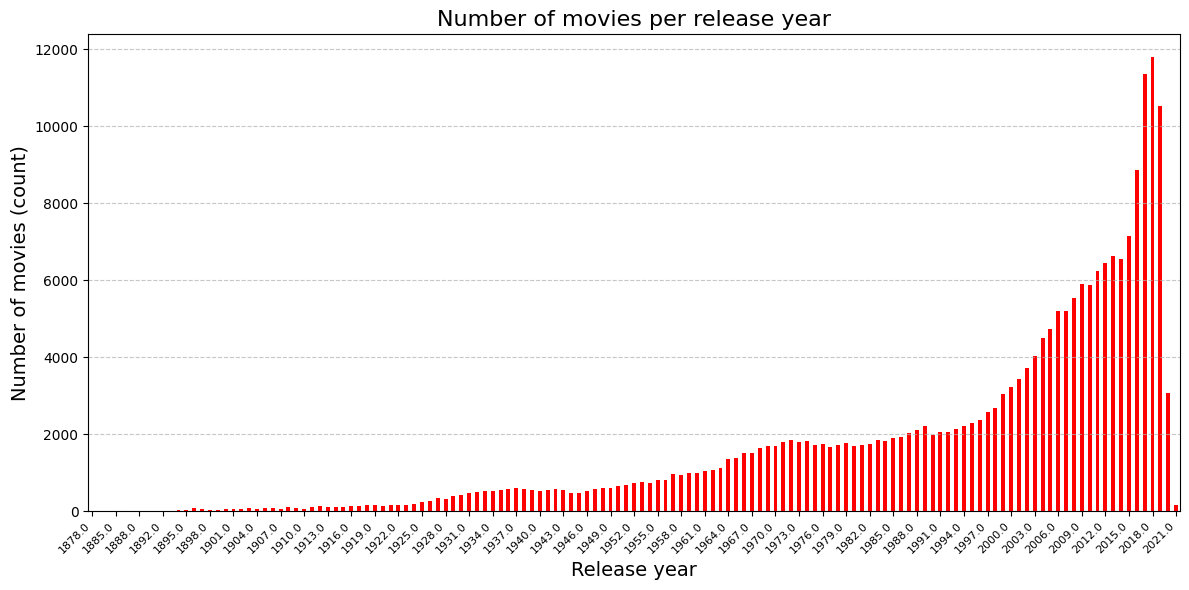

In [20]:
# Query to get the movie_release_year column
query_get_years = """
SELECT movie_release_year FROM movies;
"""

# Run the query and save the results.
release_year = pd.read_sql_query(query_get_years, connection)

# Get the 'movie_release_year' column (This creates a pandas Series).
year_series = release_year["movie_release_year"] 

# Count the occurrences of each year and sort the results by year index.
year_counts = year_series.value_counts().sort_index()

# Plot the chart.
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color="red") 
plt.title("Number of movies per release year", fontsize=16)
plt.xlabel('Release year', fontsize=14)
plt.ylabel('Number of movies (count)', fontsize=14)

# Show only every 3th tick on the x-axis.
plt.xticks(ticks=range(0, len(year_counts), 3), rotation=45, ha='right', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<span style="font-size:13pt;">***Observation:*** The chart shows the platform has **more new movies** (post-2000), but there's a drastic drop from 2019 to 2021, suggesting that it happend because the last extraction of the data was in 2020 and the users didnt has ti,e to rate the movies. This means the observed bias toward older films is due to **audience preference**, not database skew.

<span style="font-size:13pt;">***Next step:*** **Retrieve** movie rating counts per release year, convert them into **yearly percentages** (to standardize the data), and plot the trend of each rating percentage (e.g., % of 5.0s, % of 1.0s) over time as distinct lines. The analysis will focus on the period **1950–2019** to remove noise from early years (not too many movies) and the incomplete data tail.</span>

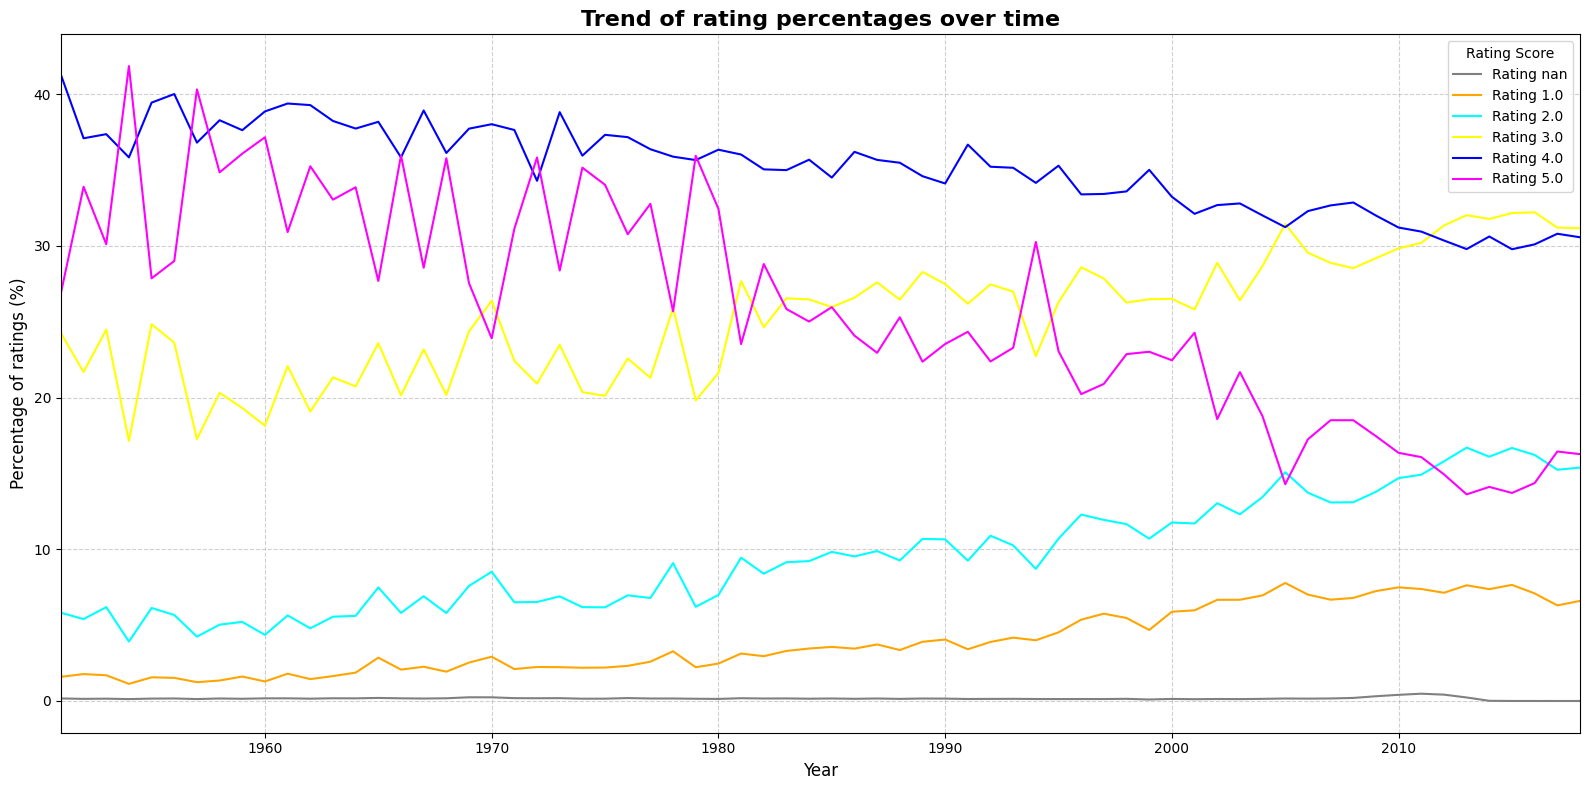

In [21]:
#Query to get how many times each unique rating score occurred for movies released from 1950 until 2019, grouped by the movie's release year.
query_ratings_year = """
SELECT m.movie_release_year, r.rating_score, COUNT(*) AS rating_count
FROM movies AS m
JOIN ratings AS r
ON m.movie_id = r.movie_id
WHERE m.movie_release_year > 1950 AND m.movie_release_year < 2019
GROUP BY m.movie_release_year, r.rating_score
ORDER BY m.movie_release_year, r.rating_score;
"""

# Run the query and save the results.
df_year_ratings = pd.read_sql_query(query_ratings_year, connection)

# Pivot the data to create a table for the line chart
df_pivot = df_year_ratings.pivot(
    index="movie_release_year",
    columns="rating_score",
    values="rating_count"
).fillna(0)

# Converts raw rating counts into percentages for each year.
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 8)) 

# Define distinct color palette.
colors = {
    'nan': 'grey',
    '1.0': 'orange',
    '2.0': 'cyan',
    '3.0': 'yellow',
    '4.0': 'blue',
    '5.0': 'magenta' 
}

# Drawing the multiple line graphs (one for each rating score) onto the plot.
for rating in df_percent.columns:
    plt.plot(
        df_percent.index, 
        df_percent[rating], 
        label=f"Rating {rating}", 
        color=colors.get(str(rating)) # Use defined color
    )

plt.title("Trend of rating percentages over time", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of ratings (%)", fontsize=12)
plt.legend(title="Rating Score")
plt.grid(alpha=0.6, linestyle='--')
plt.xticks(range(1950, 2021, 10)) # Set clear year ticks
plt.margins(x=0) # Remove padding on the sides of the x-axis
plt.tight_layout()
plt.show()

<span style="font-size:13pt;">***Observation:*** The line chart tells an interesting story. The percentage of **Rating 5.0** and **Rating 4.0** has been **slowly decreasing** since the 1970s, while lower ratings (1.0-3.0) have been slowly increasing. This confirms that **older movies are rated higher**.

<span style="font-size:13pt;">***Next step:*** Investigate if `movie_popularity` also shows audience preference for older movies by measuring the **average popularity per release year** across the same time period (1950–2019).</span>

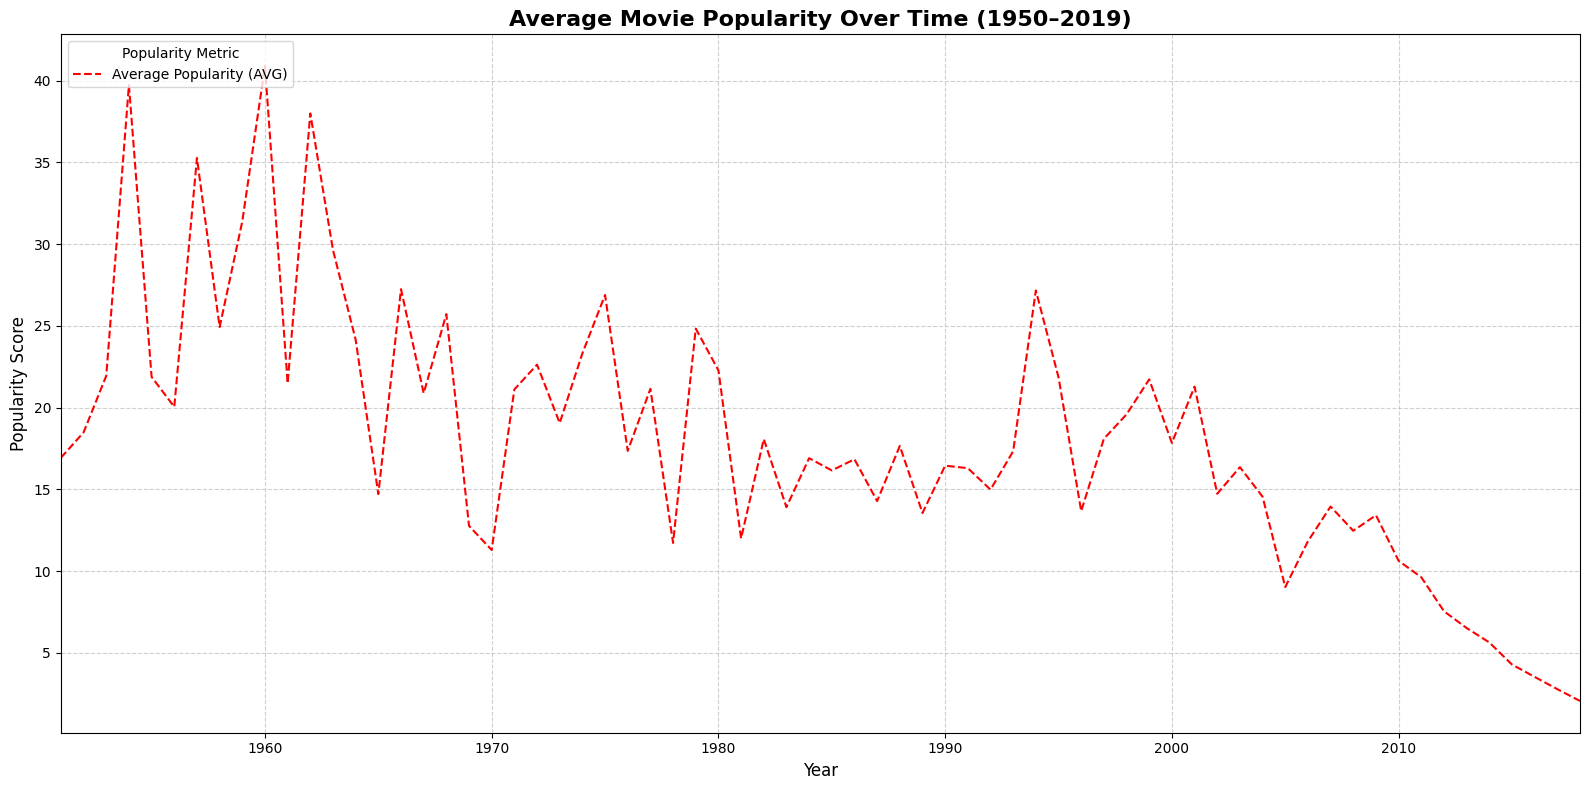

In [22]:
# Query to calculate the average movie_popularity per release year (1950–2019).
query_popularity_year = """
SELECT m.movie_release_year, AVG(m.movie_popularity) AS average_popularity
FROM movies AS m
WHERE m.movie_release_year > 1950 AND m.movie_release_year < 2019
GROUP BY m.movie_release_year
ORDER BY m.movie_release_year;
"""


# Run the query and save the results.
df_popularity_year = pd.read_sql_query(query_popularity_year, connection) 
plt.figure(figsize=(16, 8)) 

plt.plot(
    df_popularity_year['movie_release_year'],
    df_popularity_year['average_popularity'],
    label="Average Popularity (AVG)",
    color='red',
    linestyle='--'
)

plt.title("Average Movie Popularity Over Time (1950–2019)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Popularity Score", fontsize=12)
plt.legend(title="Popularity Metric", loc='upper left')
plt.grid(alpha=0.6, linestyle='--')
plt.xticks(range(1950, 2021, 10))
plt.margins(x=0)
plt.tight_layout()
plt.show()

<span style="font-size:13pt;">***Conclusion:*** The last three charts confirm a **strong preference for older movies** among MUBI users: despite the platform containing more recent releases, both rating scores and average popularity scores are consistently lower for newer films. This solidifies the hypothesis that **users prefer classic cinema quality over modern quantity**. To fully contextualize this bias, future analysis would require external data, such as: movie listing date on the platform, historical promotional data, and platform user growth over time.</span>

<span style="font-size:20pt;">**5. Director Performance Analysis**</span>

Analyzing the most and least popular directors on the platform is crucial for developing effective promotional and talent acquisition strategies.

<span style="font-size:13pt;">***Next step:*** Identify the **Top 10 most popular directors** based on the aggregated `movie_popularity` score of all their films. </span>

In [23]:
# Query to get the top 10 directors with the most popular and rated movies on average. 
query_top_directors = """
SELECT m.director_id, m.director_name, AVG(m.movie_popularity) AS average_popularity, AVG(r.rating_score) AS average_rating,
COUNT(m.movie_title) AS number_of_movies
FROM movies AS m
LEFT JOIN ratings AS r
ON m.movie_id = r.movie_id
GROUP BY m.director_id
ORDER BY average_popularity DESC, number_of_movies DESC , average_rating DESC
LIMIT 10;
"""

# Run the query and save the results.
df_top_directors = pd.read_sql_query(query_top_directors, connection)

# Show the results.
df_top_directors

,director_id,director_name,average_popularity,average_rating,number_of_movies
0,1157,Stanley Kubrick,8783.619374,4.221006,197249
1,13091,Francis Ford Coppola,8235.474194,4.250456,104354
2,1264,Quentin Tarantino,6920.383591,3.981695,183839
3,"2447, 2443","Kátia Lund, Fernando Meirelles",6543.000000,4.223701,21648
4,1564,Jean-Pierre Jeunet,6511.714107,3.894401,34387
5,539,Michel Gondry,5965.190301,3.825912,58481
6,"3197, 3198","Joel Coen, Ethan Coen",5567.646889,3.974592,128815
7,2089,Orson Welles,5366.299392,4.244795,46237
8,"1600, 3598","Terry Gilliam, Terry Jones",5285.000000,4.147607,19591
9,18011,Andrew Stanton,5246.286311,3.997592,23684


<span style="font-size:13pt;">***Next step:*** Plot the data.</span>

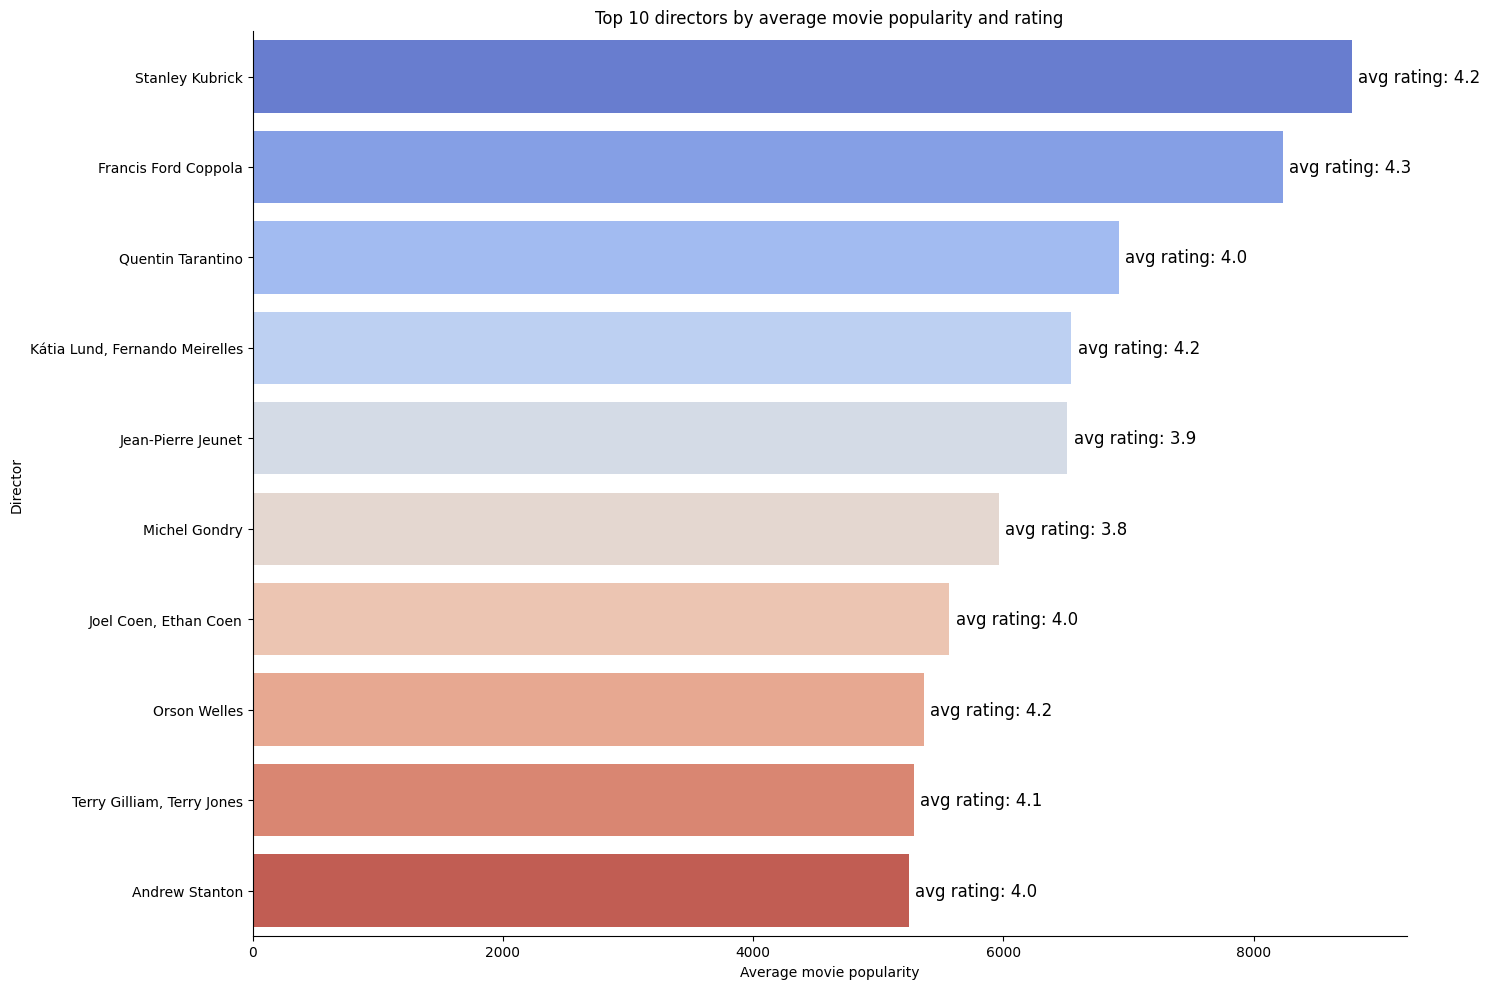

In [24]:
# Plot the list above for visual interpretation.
plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_top_directors, y="director_name", x="average_popularity",hue="director_name", palette="coolwarm")

# Remove the right and top spines of the plot.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Annotate the bars with average_rating 
for index, row in df_top_directors.iterrows():
    # Format the rating as text, e.g., "7.8/10"
    rating_text = f"avg rating: {row['average_rating']:.1f}" 
    
    ax.text(
        x=row['average_popularity'] +50,  # Position x slightly past the bar
        y=index,                          # Position y on the center of the bar
        s=rating_text,                    # The text content
        va='center',                      # Vertical alignment: center
        color='black',
        fontsize=12
    )

plt.title("Top 10 directors by average movie popularity and rating")
plt.xlabel("Average movie popularity")
plt.ylabel("Director")
plt.tight_layout()
plt.show()

<span style="font-size:13pt;">***Next step:*** Find out the least popular directors.</span>

In [25]:
# Query to identify the Top 10 directors with the most unseen movies, and then calculate their total film count and total popularity score.
query_no_ratings_final = """
WITH TopUnseenDirectors AS (
SELECT m.director_id, COUNT(m.movie_id) AS num_unseen_movies
FROM movies AS m
LEFT JOIN ratings AS r
ON m.movie_id = r.movie_id
WHERE r.movie_id IS NULL AND m.movie_release_year < 2019 AND m.movie_popularity = 0
GROUP BY m.director_id
ORDER BY num_unseen_movies DESC)

SELECT tud.num_unseen_movies, m.director_name, COUNT(m.movie_id) AS total_movies_on_platform, SUM(m.movie_popularity) AS total_popularity_score
FROM movies AS m
JOIN TopUnseenDirectors AS tud 
ON m.director_id = tud.director_id
GROUP BY m.director_id, tud.num_unseen_movies
ORDER BY tud.num_unseen_movies DESC
LIMIT 10;
"""

# Run the query and save the results.
df_no_ratings = pd.read_sql_query(query_no_ratings_final, connection)

# Show the results.
print("--- Directors with Most Unseen Movies and their Total Metrics ---")
df_no_ratings

--- Directors with Most Unseen Movies and their Total Metrics ---


,num_unseen_movies,director_name,total_movies_on_platform,total_popularity_score
0,284,(Unknown),760,78
1,169,Andy Warhol,253,444
2,65,Joseph Kane,85,2
3,58,Dietmar Brehm,75,7
4,57,David DeCoteau,97,12
5,55,Dave Fleischer,179,369
6,53,Otto Messmer,62,6
7,51,Sam Newfield,71,2
8,49,Georges Méliès,188,3262
9,48,Pieter Moleveld,48,0


<span style="font-size:13pt;">***Conclusion:*** The Director Performance Analysis yields key insights for **Content Acquisition** and **Data Management**:</span> 

* **Top Talent Focus:** The plot confirms **Stanley Kubrick**, **Francis Ford Coppola**, and the rest of the Top 10 are the dominant, most engaging directors and should be the focus of premium promotions.
* **Data Integrity Crisis:** The top entry is **(Unknown)** ($\text{284}$ unseen movies out of $\text{760}$ total, with only $\text{78}$ total popularity). This indicates a **critical data integrity problem** (missing director names) associated with **dead content** that needs immediate investigation and cleanup by the data team.</span> 
 
### Content Acquisition Strategy

<span style="font-size:13pt;">The remaining directors with high counts of unseen content fall into two actionable categories:</span> 

* **Low-Value Acquisition:** Directors like **Joseph Kane** ($\text{65}$ unseen, $\text{23}$ total popularity) and **Dietmar Brehm** ($\text{58}$ unseen, $\text{57}$ total popularity) have a high number of movies with zero ratings and extremely low total popularity. This strongly suggests these directors represent **ineffective, low-engagement acquisition choices**. Future purchasing should avoid content from these types of directors.
* **Targeted Inspection Required:** Directors like **Andy Warhol** and **Georges Méliès** have a large volume of unseen content but also have some total popularity. A dedicated analysis is required here to determine if the unseen movies are simply **unpopular outliers** (mixed quality acquisitions) or **redundant versions/duplicates** of their successful films.

<span style="font-size:20pt;">**6.Unrated Content**</span>

As seen in the Director Analysis, there are a significant number of movies with zero reviews. This section inspects the volume and characteristics of unrated content to better understand platform engagement and content gaps.

<span style="font-size:13pt;">***Next step:*** Calculate the **total number of unrated movies** and the **proportion** they represent of the entire film library to establish the scale of the engagement problem.</span>

In [26]:
# Query to get the number of movies with no ratings in the␣`ratings` table
query_no_ratings = """
SELECT COUNT(*) AS total_movies_no_reviews
FROM movies AS m
LEFT JOIN ratings AS r
ON m.movie_id = r.movie_id
WHERE r.movie_id IS NULL AND m.movie_release_year < 2019
;
"""
# Run the query and save the results.
df_no_ratings = pd.read_sql_query(query_no_ratings, connection)

# Show the results
df_no_ratings

,total_movies_no_reviews
0,75964


In [27]:
print("Movies with no reviews comprise",(df_no_ratings["total_movies_no_reviews"]/df_movie_counts["unique_movie_ids"]*100).values[0], "% of the movies in the database.")

Movies with no reviews comprise 33.52708816065321 % of the movies in the database.


<span style="font-size:13pt;">***Conclusion:*** The analysis confirms that **$\text{75,964}$ movies** (pre-2019), or **$\text{33.53\%}$** of the library, have **zero user ratings**. This massive volume of "dead content" indicates a failure in acquisition strategy, leading to wasted resources (storage, licensing, maintenance). The acquisition strategy must be urgently changed.

<span style="font-size:13pt;">***Next step:*** Analyze the **distribution of unrated movies over time** (by release year) to identify when this low-engagement content was acquired, informing future acquisition policies.</span>

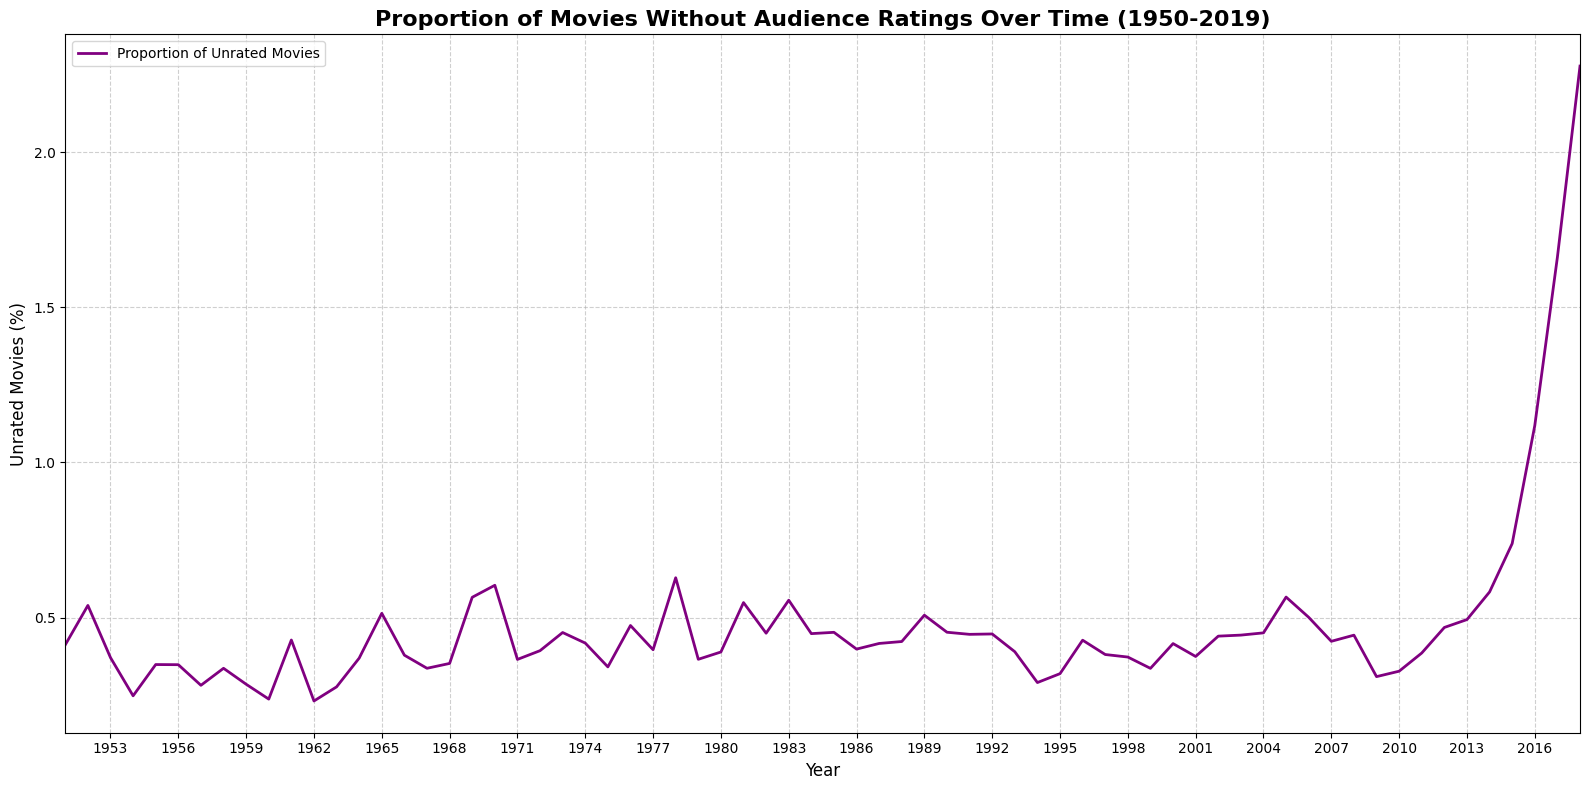

In [28]:
# Query to calculate the total number of movies and the number of unrated movies for each year between 1950 and 2019.
query_review_proportion = """
SELECT m.movie_release_year, COUNT(m.movie_id) AS total_movies, SUM(CASE WHEN r.movie_id IS NULL THEN 1 ELSE 0 END) AS unrated_movies
FROM movies AS m
LEFT JOIN ratings AS r
ON m.movie_id = r.movie_id
WHERE m.movie_release_year > 1950 AND m.movie_release_year < 2019
GROUP BY m.movie_release_year
ORDER BY m.movie_release_year;
"""

# Run the query and save the results.
df_review_proportion = pd.read_sql_query(query_review_proportion, connection)

# Calculate the proportion (percentage) of unrated movies for each year.
df_review_proportion['unrated_proportion'] = (df_review_proportion['unrated_movies'] / df_review_proportion['total_movies']) * 100

plt.figure(figsize=(16, 8)) 

# Plot the calculated proportion over time
plt.plot(df_review_proportion['movie_release_year'], df_review_proportion['unrated_proportion'],
label="Proportion of Unrated Movies",color='purple',linewidth=2)

plt.title("Proportion of Movies Without Audience Ratings Over Time (1950-2019)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unrated Movies (%)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.6, linestyle='--')
plt.xticks(range(1950, 2019, 3))
plt.margins(x=0)
plt.tight_layout() 
plt.show()

<span style="font-size:13pt;">***Conclusion:*** The trend of unrated movies confirms a critical content problem. The proportion of movies with zero ratings shows a clear and significant **upward trend**, peaking in the most recent years (2010s).

<span style="font-size:13pt;">While the platform acquired **more movies** with newer release years compared to older release years (reflecting increased recent global production), the audience's willingness to engage (rate) them **decreased**. This is the classic scenario where **"sometimes more is less"**—cluttering the platform with less-curated content discourages user interaction.

<span style="font-size:13pt;">***Next step:*** Synthesize all findings into a final **Executive Summary** and a concise list of **Recommendations** for the streaming platform's stakeholders.</span>

In [29]:
connection.close()

## 📈 Executive Summary: Content Strategy Review 

The Analysis reveals a critical misalignment between the platform's content acquisition strategy and its highly engaged, curatorial audience. The platform has successfully built a library of high-quality **classic cinema** but has severely diluted its value with recent acquisitions, leading to a drop in engagement quality and significant resource waste.

---

### 1. Audience Preference: Classics Over Quantity

* **Bias Confirmed:** The audience demonstrates a clear preference for older movies. The highest ratings (4.0 and 5.0) have been **steadily decreasing** for newer films since the 1950s. Consequently, both **average rating scores** and **average popularity scores** have also decreased.
* **Genre Focus:** Promotional focus should be placed on **Drama, Crime, and Sci-Fi** films, as these genres consistently drive the highest engagement.

### 2. Content Dilution & Resource Waste

* **Dead Content:** **$\text{33.53\%}$** of the entire film library (over $\text{75,000}$ movies pre-2019) has generated **zero user ratings**.
* **Trend:** The proportion of unrated movies shows a clear and significant **upward trend**, peaking in the most recent years. This confirms that acquiring more recent content (since the industry is producing more) resulted in clutter and discouraged user interaction—a scenario where **"sometimes more is less."**

### 3. Director Performance (Actionable Acquisition Report)

* **Top Talent:** Directors like **Stanley Kubrick** and **Francis Ford Coppola** drive the highest average popularity, with the rest of the Top 10 list detailed in the full analysis. These should be the focus of premium promotions.
* **Acquisition Failure:** Directors like **Joseph Kane** and **Dietmar Brehm** (more in the list of the analysis) represent an entire filmography of **ineffective, low-engagement acquisitions** and should be avoided in future purchasing.

---

### 4. Critical Data Integrity and Technical Flaws (Data/Security Focus)

The Data Cleaning phase uncovered severe flaws in data ingestion and storage that require immediate attention:

* **Primary Key Failure (Technical):** The `ratings` table had a critical primary key failure with $\text{8}$ duplicated `rating_id` values.
* **Referential Integrity Flaw (Technical/Data Engineering):** $\text{34}$ ratings were recorded referencing a `movie_id` that **does not exist** in the `movies` table.
* **Security/Data Collection Flaw:** $\text{3}$ user ratings were missing mandatory user characteristic fields. The specific User IDs ($\text{38478306}$, $\text{46159561}$, and $\text{94559170}$) must be reported to the **security and data collection teams** to investigate how these records bypassed mandatory field checks.
* **Metadata Gaps:** The **(Unknown) director** entry and other low-popularity rows with missing core metadata require cleanup and a fix in the metadata ingestion pipeline.

* **Important note:** The **`movie_title` is not a unique identifier** ($\text{29,947}$ duplicated titles). This must be communicated to development teams to prevent logic errors in features that rely on film title alone.

---

### 5. Subject for Further Analysis

The claims in this report are **initial findings** based solely on the `movies` and `ratings` tables and should **not be taken as a final verdict**. A comprehensive analysis requires integrating the remaining datasets.

* **Advanced Director Inspection:** Further analysis is needed for directors with high total popularity (e.g., Andy Warhol) but large unseen catalogs to determine if the unrated content is due to low quality or **redundant duplicates**.
* 
* **Further Analysis (Existing Data):** Analysis of the remaining tables is necessary to understand **user behavior and characteristics**.
* **Further Analysis (New Data Required):** A full assessment requires obtaining additional data points not present in the current dataset, including: user amounts along the years, time of movie upload to the platform, and historical promotion details to verify the claims and provide a complete picture.